# Get summary statistics
Let's get statistics for the loanword authors.

In [1]:
# load data
import pandas as pd
loanword_data = pd.read_csv('../../data/mined_tweets/loanword_verb_posts_CLUSTER=twitter_posts_STARTDATE=2017_7_9_ENDDATE=2019_4_6.tsv', sep='\t')
loanword_data.fillna('', inplace=True)

## Loanword frequency

In [7]:
loanword_counts = loanword_data.loc[:, 'loanword'].value_counts()
display(loanword_counts.head(10))

like       13154
connect     7857
flip        6904
stalk       5508
tweet       5294
flash       4572
ship        4014
hack        3877
push        3538
post        3082
Name: loanword, dtype: int64

## Media statistics
Let's look at the most frequently shared musicians among the loanword authors.

In [1]:
import pandas as pd
# get author sharing counts
author_music_share_data = pd.read_csv('../../data/mined_tweets/loanword_author_tweets_all_archives_author_spotify_link_data.tsv', sep='\t')
author_video_share_data = pd.read_csv('../../data/mined_tweets/loanword_author_tweets_all_archives_youtube_video_categories.tsv', sep='\t')
# display(author_music_share_data.head())
# display(author_video_share_data.head())
# get music ID data
music_ID_data = pd.read_csv('../../data/culture_metadata/spotify_musician_data.tsv', sep='\t', 
                            usecols=['artist_id', 'name'])
video_ID_data = pd.read_csv('../../data/culture_metadata/youtube_video_music_genre_data.tsv', sep='\t', 
                            usecols=['youtube_id', 'latin_american_artist_tags', 'us_american_artist_tags'],
                            converters={'latin_american_artist_tags' : eval, 'us_american_artist_tags' : eval})
# clean up data for merging
author_music_share_data = author_music_share_data.assign(**{
    'artist_genre' : author_music_share_data.loc[:, ['latin_american_genre', 'us_american_genre']].apply(lambda x: 'latin_american_artist' if x[0] else 'us_american_artist' if x[1] else '', axis=1)
})
music_ID_data = music_ID_data.assign(**{
    'name' : music_ID_data.loc[:, 'name'].apply(lambda x: [x.lower()])
})
music_ID_data.rename(columns={'name' : 'artist_names'}, inplace=True)
author_video_share_data.rename(columns={'youtube_id_category': 'artist_genre'}, inplace=True)
video_ID_data = video_ID_data.assign(**{
    'artist_names' : video_ID_data.loc[:, ['latin_american_artist_tags', 'us_american_artist_tags']].apply(lambda x: x[0] | x[1], axis=1)
})

# display(music_ID_data.head())
# display(video_ID_data.head())
# combine:
# track ID | artist names | screen name | genre
author_music_share_data = pd.merge(author_music_share_data, music_ID_data, on='artist_id')
author_video_share_data = pd.merge(author_video_share_data, video_ID_data.loc[:, ['youtube_id', 'artist_names']], on='youtube_id')
# display(author_music_share_data.head())
# display(author_video_share_data.head())
author_music_share_data = author_music_share_data.assign(**{
    'media_type' : 'music'
})
author_video_share_data = author_video_share_data.assign(**{
    'media_type' : 'video'
})
author_media_data = pd.concat([author_music_share_data, author_video_share_data], axis=0)
author_media_data = author_media_data.loc[:, ['screen_name', 'artist_genre', 'artist_names', 'media_type']]
# fix null genres
author_media_data = author_media_data.assign(**{
    'artist_genre' : author_media_data.loc[:, 'artist_genre'].apply(lambda x: 'other' if x=='' else x)
})
# fix genre names for plot
clean_genre_lookup = {
    'latin_american_artist' : 'Spanish/Latin American',
    'us_american_artist' : 'US/UK',
    'other' : 'Other'
}
author_media_data = author_media_data.assign(**{
    'artist_genre' : author_media_data.loc[:, 'artist_genre'].apply(clean_genre_lookup.get)
})
display(author_media_data.head())

,screen_name,artist_genre,artist_names,media_type
0,aneuroma,US/UK,[megadeth],music
1,kikideltwit,US/UK,[megadeth],music
2,dookiemosh,US/UK,[megadeth],music
3,aneuroma,US/UK,[megadeth],music
4,aneuroma,US/UK,[megadeth],music


In [2]:
# compute artist counts per genre
# genre | artist | count
artist_genre_counts = []
for idx_i, data_i in author_media_data.iterrows():
    for name_j in data_i.loc['artist_names']:
        artist_genre_counts.append([name_j, data_i.loc['artist_genre'], data_i.loc['media_type']])
artist_genre_counts = pd.DataFrame(artist_genre_counts, columns=['artist_name', 'artist_genre', 'media_type'])
top_k = 10
for genre_i, data_i in artist_genre_counts.groupby('artist_genre'):
    print(f'top counts for genre {genre_i}')
    artist_counts_i = data_i.loc[:, 'artist_name'].value_counts()
    display(artist_counts_i.iloc[:top_k])

top counts for genre Other


bts              213
exo              134
rosalía           68
monsta x          55
darell            53
myke towers       52
radiohead         52
david bowie       49
lenny tavárez     41
brytiago          38
Name: artist_name, dtype: int64

top counts for genre Spanish/Latin American


natalia oreiro     275
sebastian yatra    247
bad bunny          244
j balvin           195
jorge blanco       172
tini stoessel      167
danna paola        161
mau y ricky        158
luis miguel        122
alejandro sanz     120
Name: artist_name, dtype: int64

top counts for genre US/UK


ariana grande        232
taylor swift         162
nicki minaj          147
camila cabello       118
halsey               117
lady gaga            111
twenty one pilots    101
miley cyrus           99
katy perry            99
lana del rey          98
Name: artist_name, dtype: int64

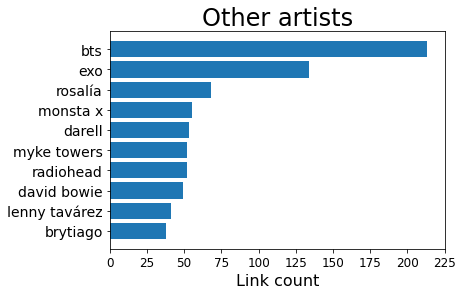

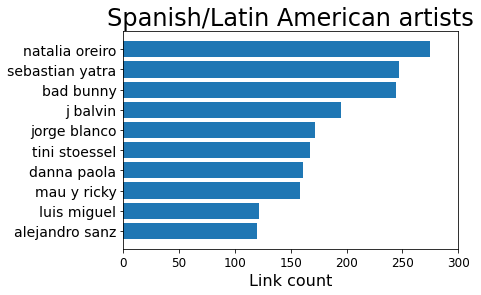

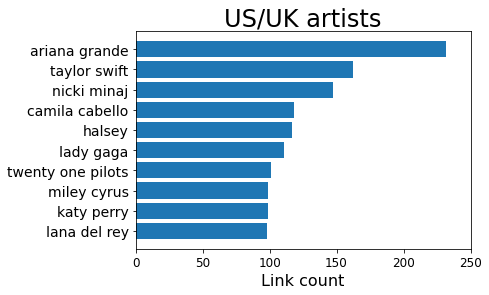

In [3]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
top_k = 10
X = np.arange(top_k)
for genre_i, data_i in artist_genre_counts.groupby('artist_genre'):
    artist_counts_i = data_i.loc[:, 'artist_name'].value_counts()[:top_k][::-1]
#     clean_genre_i = ' '.join(list(map(lambda x: x.capitalize(), genre_i.replace('_', ' ').replace(' artist', '').split(' '))))
    plt.barh(X, artist_counts_i)
    plt.xlabel('Link count', fontsize=16)
    x_ticks, x_tick_labels = plt.xticks()
    plt.xticks(x_ticks, fontsize=12)
    plt.yticks(X, artist_counts_i.index, fontsize=14)
    plt.title(f'{genre_i} artists', fontsize=24)
    plt.show()

## Native verb frequency

In [5]:
import pandas as pd
native_verb_counts = pd.read_csv('../../data/mined_tweets/native_verbs_post_social_data.tsv', sep='\t')
print(native_verb_counts.shape[0])
display(native_verb_counts.head())
print(native_verb_counts.loc[:, 'native_word_type'].value_counts())

328651


,screen_name,id,date,text,native_word_category,native_word_type,has_light_verb,description_location_region,es,total_video_count,...,log_latin_american_media_pct,log_media_URL_pct,log_integrated_verb_pct,log_post_pct,log_URL_share_pct,log_RT_pct,log_balanced_latin_american_media_pct,es_bin,latin_american_media_pct_bin,balanced_latin_american_media_pct_bin
0,000822e5bc974e0,914139329345343488,NaN,Por eso en Guatemala se hace imperativo la int...,native_integrated_verb,terminar,0,latin_america,0.952482,NaN,...,NaN,NaN,-0.094311,0.817638,-3.956807,-2.605467,NaN,es_mid,NaN,NaN
1,000822e5bc974e0,1056780245154648067,2018-10-29 01:30:19,Es que manda a decir un diputado que solo alca...,native_integrated_verb,comprar,0,latin_america,0.952482,NaN,...,NaN,NaN,-0.094311,0.817638,-3.956807,-2.605467,NaN,es_mid,NaN,NaN
2,000822e5bc974e0,1056620451475218432,2018-10-28 14:55:21,# DepresiónCacifNoMeQuiere Consejos. Que me re...,native_integrated_verb,recomendar,0,latin_america,0.952482,NaN,...,NaN,NaN,-0.094311,0.817638,-3.956807,-2.605467,NaN,es_mid,NaN,NaN
3,000822e5bc974e0,1056398890696609792,2018-10-28 00:14:57,Me preocupa que usted no sepa lo que preocupa ...,native_integrated_verb,preguntar,0,latin_america,0.952482,NaN,...,NaN,NaN,-0.094311,0.817638,-3.956807,-2.605467,NaN,es_mid,NaN,NaN
4,000822e5bc974e0,1056373148453613568,2018-10-27 22:32:39,# Olancho # Honduras nueva # CaravanaDeMigrant...,native_integrated_verb,preguntar,0,latin_america,0.952482,NaN,...,NaN,NaN,-0.094311,0.817638,-3.956807,-2.605467,NaN,es_mid,NaN,NaN


soñar           39392
comprar         36337
terminar        34234
usar            30834
probar          29930
preguntar       16936
mirar           15001
participar      13917
decidir         12479
recomendar      11450
explicar        11342
volar           11164
viajar          10255
dañar            5035
disculpar        4354
respirar         3814
saltar           3754
mencionar        3684
negociar         3064
culpar           2546
pasear           2474
dudar            2378
anotar           2358
copiar           2090
animar           1997
pisar            1946
finalizar        1829
burlar           1793
prever           1383
multar           1302
originar         1243
castigar         1216
fotografiar      1149
admirar           988
redactar          861
estimar           824
aterrizar         700
vistar            690
fugar             574
bromear           422
duchar            277
ejemplificar      206
remediar          148
preciar           102
cosquillar         87
sestear   